## Methods to compare in integration tasks

Harmony and Liger are widely-used data integration / batch effect correction methods that have Python implementations. Harmony is usually considered to be less aggressive in strength, thus keeping more biological variance. Liger is suitable in situations with more severe batch effect.

In [1]:
import sklearn as skl
import pickle as pkl
import pandas as pd
import numpy as np

import sklearn.model_selection
import sklearn.svm
import sklearn.metrics

import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
import seaborn as sns

from itertools import chain

In [2]:
import scipy as sp

In [3]:
import math
import numpy as np

In [4]:
import sys
sys.path.append("..") # or wherever the package is

In [6]:
import scanpy as sc

In [19]:
import harmonypy as hm
import pyliger

C:\Users\lshh\miniconda3\envs\py39_integration\lib\site-packages\umap\plot.py:203: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.


## Load data and view the data without integration

In [10]:
adata = sc.read_h5ad('data/demo1_sp_adata.h5ad')

chosen_slices = ['MsBrainAgingSpatialDonor_5_0', 'MsBrainAgingSpatialDonor_6_0', 
                 'MsBrainAgingSpatialDonor_7_0']

adata = adata[adata.obs['donor_slice'].isin(chosen_slices), :]

C:\Users\lshh\miniconda3\envs\py39_integration\lib\site-packages\anndata\_core\anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


In [11]:
sc.tl.pca(adata)

In [12]:
sc.pp.neighbors(adata)

In [13]:
sc.tl.umap(adata)

C:\Users\lshh\miniconda3\envs\py39_integration\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(
C:\Users\lshh\miniconda3\envs\py39_integration\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
C:\Users\lshh\miniconda3\envs\py39_integration\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
C:\Users\lshh\miniconda3\envs\py39_integration\lib\site-packages\scanpy\plotting\_tool

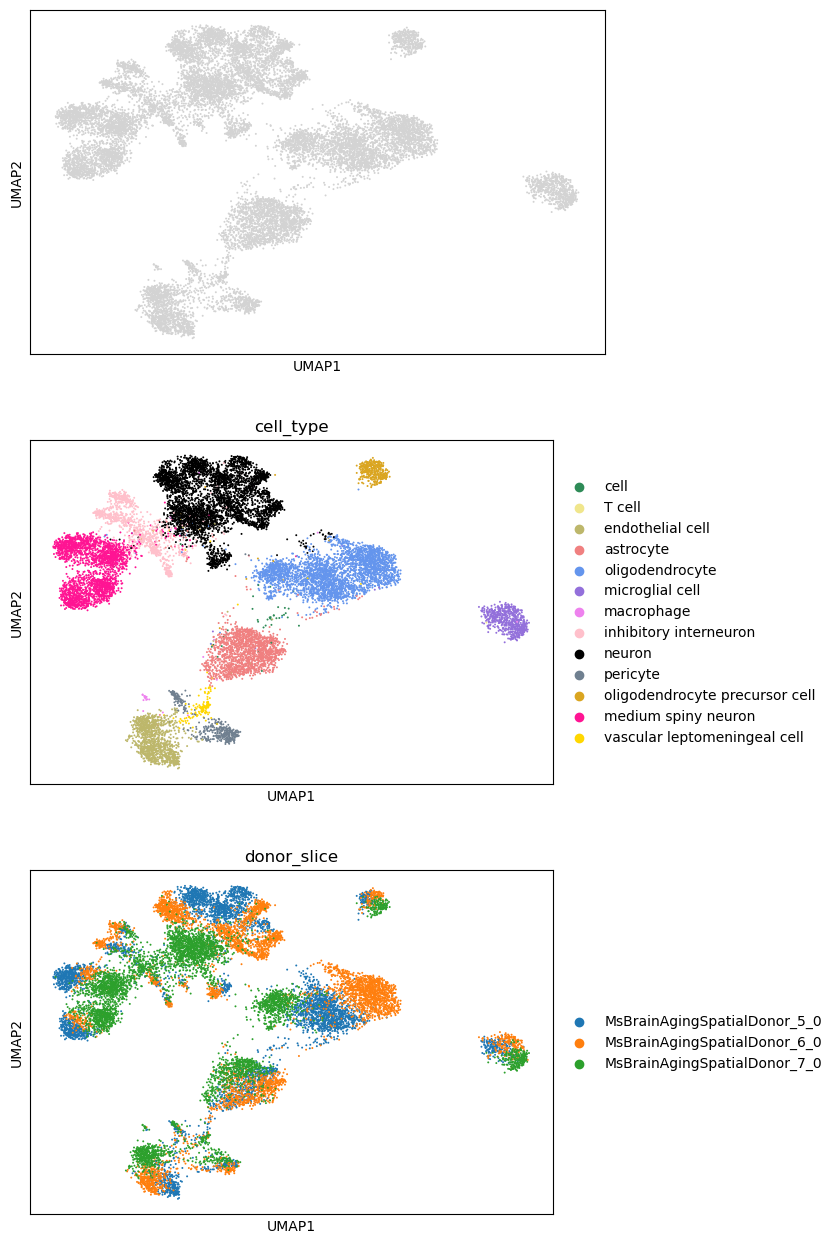

In [14]:
sc.pl.umap(adata, color=[None, 'cell_type', 'donor_slice'], ncols=1)

## Harmony integration

In [15]:
ho = hm.run_harmony(adata.obsm['X_pca'], adata.obs[['donor_slice']], ['donor_slice'])

2023-09-30 17:55:59,655 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2023-09-30 17:56:06,169 - harmonypy - INFO - sklearn.KMeans initialization complete.
2023-09-30 17:56:06,304 - harmonypy - INFO - Iteration 1 of 10
2023-09-30 17:56:13,491 - harmonypy - INFO - Iteration 2 of 10
2023-09-30 17:56:20,958 - harmonypy - INFO - Iteration 3 of 10
2023-09-30 17:56:29,234 - harmonypy - INFO - Iteration 4 of 10
2023-09-30 17:56:31,994 - harmonypy - INFO - Iteration 5 of 10
2023-09-30 17:56:35,307 - harmonypy - INFO - Iteration 6 of 10
2023-09-30 17:56:37,928 - harmonypy - INFO - Iteration 7 of 10
2023-09-30 17:56:40,401 - harmonypy - INFO - Iteration 8 of 10
2023-09-30 17:56:42,900 - harmonypy - INFO - Converged after 8 iterations


In [16]:
res = pd.DataFrame(ho.Z_corr)
res.columns = ['X{}'.format(i + 1) for i in range(res.shape[1])]
adata.obsm['X_harmony'] = res.to_numpy().T

C:\Users\lshh\miniconda3\envs\py39_integration\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(
C:\Users\lshh\miniconda3\envs\py39_integration\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
C:\Users\lshh\miniconda3\envs\py39_integration\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
C:\Users\lshh\miniconda3\envs\py39_integration\lib\site-packages\scanpy\plotting\_tool

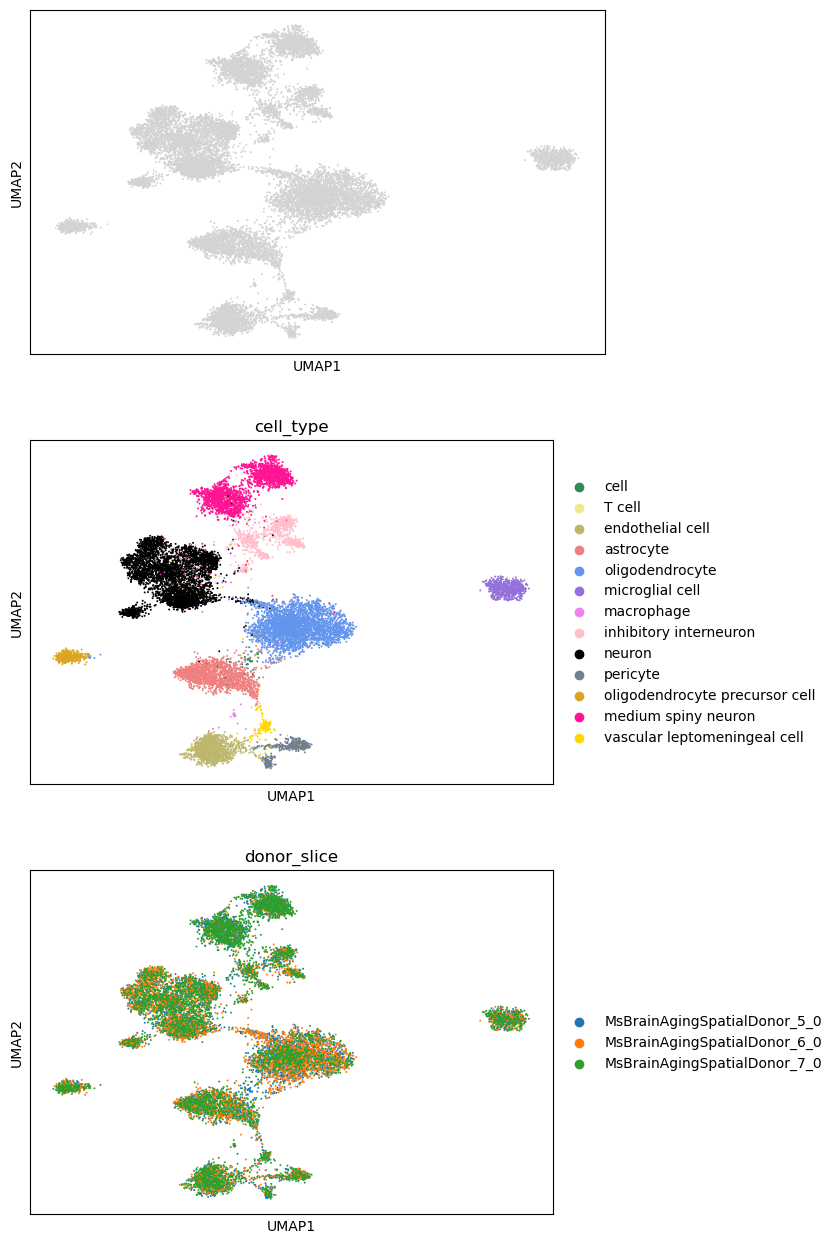

In [17]:
sc.pp.neighbors(adata, use_rep='X_harmony')
sc.tl.umap(adata)
sc.pl.umap(adata, color=[None, 'cell_type', 'donor_slice'], ncols=1)

## Liger

In [29]:
adatas = []
for i in chosen_slices:
    adatas.append(adata.raw.to_adata()[adata.obs['donor_slice'] == i, :])
    adatas[-1].obs.index.name = 'cell_names'
    adatas[-1].var.index.name = 'gene_names'
    adatas[-1].uns['sample_name'] = i
liger = pyliger.create_liger(adatas)

In [30]:
pyliger.normalize(liger)
pyliger.select_genes(liger)
pyliger.scale_not_center(liger)
pyliger.optimize_ALS(liger, k = 20)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:45<00:00,  1.52s/it]


In [37]:
pyliger.quantile_norm(liger)

In [38]:
adata.obsm['X_liger'] = np.vstack([adata.obsm["H_norm"] for adata in liger.adata_list])

In [46]:
sc.pp.neighbors(adata, use_rep='X_liger', metric='cosine')
sc.tl.umap(adata)

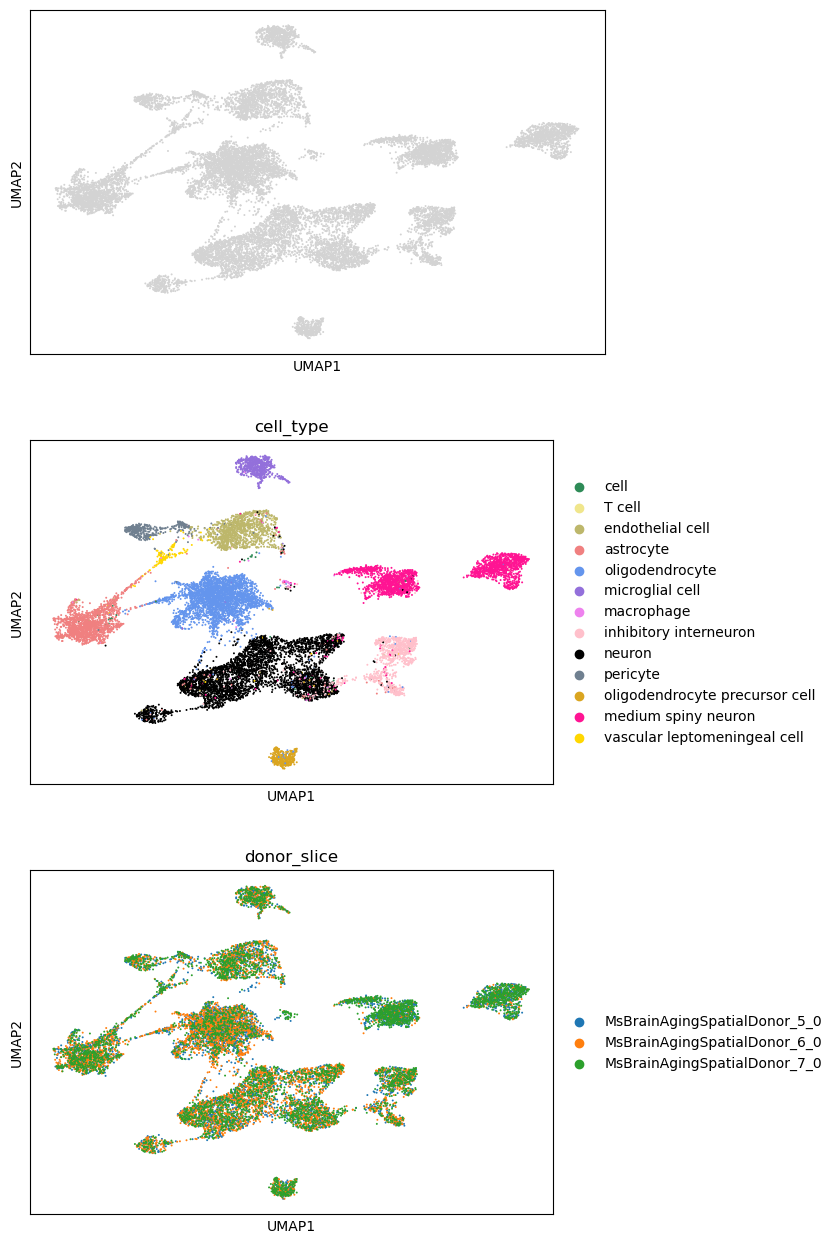

In [47]:
%matplotlib inline
sc.pl.umap(adata, color=[None, 'cell_type', 'donor_slice'], ncols=1)
pass

## Scoring and plotting 

In [48]:
import sklearn as skl

scores = {}

for method in ('liger', 'harmony', 'pca'):
    matrix_name = 'X_' + method
    s_score = skl.metrics.silhouette_score(adata.obsm[matrix_name], adata.obs['cell_type'])
    db_score = skl.metrics.davies_bouldin_score(adata.obsm[matrix_name], adata.obs['cell_type'])
    ch_score = skl.metrics.calinski_harabasz_score(adata.obsm[matrix_name], adata.obs['cell_type'])
    
scores[method] = [s_score, db_score, ch_score]

,liger,harmony,pca
0,0.271638,0.204222,0.183674
1,1.409478,1.970524,2.022068
2,1372.552238,942.128384,849.598899


In [52]:
scores = pd.DataFrame(scores, index=['silhouette', 'davies_bouldin', 'calinski_harabasz']).T
scores

,silhouette,davies_bouldin,calinski_harabasz
liger,0.271638,1.409478,1372.552238
harmony,0.204222,1.970524,942.128384
pca,0.183674,2.022068,849.598899


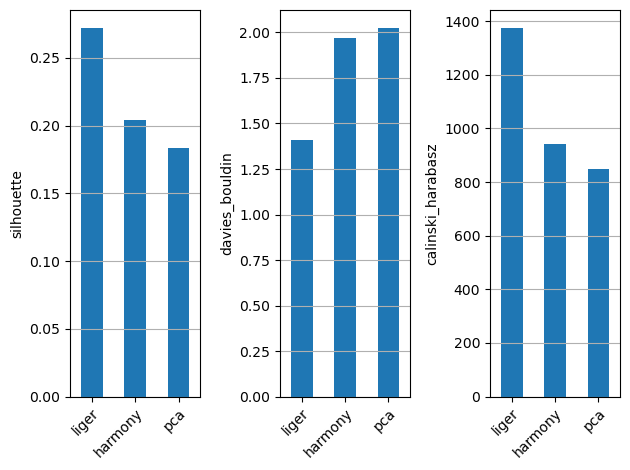

In [77]:
plt.subplots(1, 3)
for i, v in enumerate(scores.columns):
    plt.subplot(1, 3, i + 1)
    scores[v].plot(kind='bar')
    plt.ylabel(v)
    plt.grid(axis='y')
    plt.xticks(rotation=45, ha='right', rotation_mode='anchor')
plt.tight_layout()